# Optimizing array layout for all-sky radio telescopes using the condition number of the telescope operator

by Tim Molteno (tim@elec.ac.nz)

The discrete sky telescope operator [1] is a linear measurement operator that maps sky-vectors to visibility measurements. This works for arbitrary fields of view, non-coplanar baselines and non-flat skies.

Here we use the condition number of the Moore-Penrose inverse of the telescope operator as an optimization criterion for choosing antenna array layouts.


## Theory

The Moore-Penrose inverse,  $A^+$, (or pseudoinverse) of the telescope operator $A$, maps visibilities to sky-vectors. It can be interpreted as providing the solution, $s$, to the inverse problem $v = A s$, with minimum euclidian norm. Using the SVD of A we can write

$ A = U \Sigma V^H $
or
$ A^H = V \Sigma^H U^H $

and so
$ y = A x = U \Sigma V^H x $
which means:
$ V \Sigma^H U^H y = V \Sigma^H U^H U \Sigma V^H x $, and so

$ V \Sigma^H U^H y = V \Sigma^H \Sigma V^H x $

$A^+ = V \Sigma^+ U^\star$
The condition number of $A^+$ is the ratio between the largest and smallest (non-zero) singular value.

Using the pseudoinverse and a matrix norm, one can define a condition number for any matrix:

\[ cond ( A ) = ‖ A ‖ ‖ A + ‖  \]

A large condition number implies that the problem of finding least-squares solutions to the corresponding system of linear equations is ill-conditioned in the sense that small errors in the entries of A {\displaystyle A} A can lead to huge errors in the entries of the solution.[27] 


The condition number is the radio of the largest to the smallest singular values of the matrix.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

## Testing the constraining of inputs

The inputs to the optimization function must not allow negative positions along the arms (otherwise the array effectively has six arms). To ensure this we pass the list of radius values through a function that maps all values to positive numbers.

This function must be differentiable so that the gradient of the condition number can be determined.

In [2]:
x = np.linspace(-2,10,100)

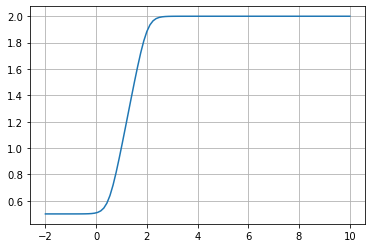

In [3]:
def constrain(x, lower, upper, sharpness=6):
    clip_lower = tf.math.softplus((x-lower)*sharpness)/sharpness + lower
    return upper - tf.math.softplus((-clip_lower + upper)*sharpness)/sharpness

y = constrain(x,0.5,2)
plt.plot(x,y.numpy())
plt.grid(True)

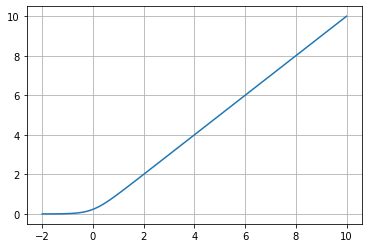

In [4]:
sharpness = 3
y = tf.math.softplus(x*sharpness)/sharpness
plt.plot(x,y.numpy())
plt.grid(True)

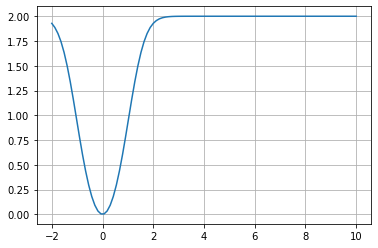

In [5]:
y = (tf.math.sigmoid(x**2)-0.5)*4
plt.plot(x,y.numpy())
plt.grid(True)

Both of these functions do pretty well at mapping all values to between 0..2.  I'll use the softmax version.

## Penalizing antennas that are close together

We need a differentiable function that is nonzero when an antenna pair is closer than some threshold.

In [6]:
def penalize(duv2, limit=0.2):
    sharpness = 50
    duv = tf.sqrt(duv2)
    clip_lower = tf.math.softplus((limit - duv)*sharpness)/sharpness
    return (clip_lower/limit)**2

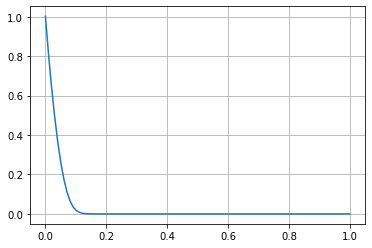

In [7]:
du = np.linspace(0,1,100)
plt.plot(du, penalize(du**2, limit=0.1))
plt.grid(True)

## Optimization Strategy

Tensorflow has recently included the derivative of the SVD operator, so we can compute the gradient of the antenna positions with respect to the condition number!. This is shit hot, and opens up standard optimization strategies to  find optimum array layouts.

### Cost Function

Penalize antennas too close together? 

### Starting Layout

Currently random, but may make sense to start with a perturbed uniform.

## Results

The advantage of using condition number as an optimization criterion is that it provides a quantitative measure of the quality of the inversion that is possible when imaging from the array.

### Choice of Optimizer

We use tensorflow which allows the use of stochastic gradient minimizers that can auto-differentiate the SVD operation. The source code for this strategy is in github [https://github.com/tmolteno/TART-3/tree/master/array/disko_array_opt].

In [8]:
import json
with open('best.json', 'r') as f:
    results = json.load(f)

results['condition_number']

4.363842077438133

In [9]:
import array_opt
ant = array_opt.YAntennaArray.from_json('best.json')

INFO: nside=1 res=3517.9380857010237 arcmin
INFO: nside=2 res=1758.9690428505119 arcmin
INFO: nside=4 res=879.4845214252559 arcmin
INFO: nside=8 res=439.74226071262797 arcmin
INFO: nside=16 res=219.87113035631398 arcmin
INFO: nside=32 res=109.93556517815699 arcmin
INFO: New SubSphere, nside=32
INFO: New SubSphere, nside=32. npix=5056


Text(0.5, 1.0, 'Optimized antenna layout')

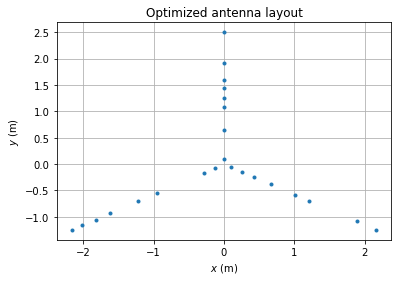

In [10]:
ant_pos = ant.get_ant_pos(ant.arms)
plt.plot(ant_pos[:,0], ant_pos[:,1], '.')
plt.grid(True)
plt.xlabel("$x$ (m)")
plt.ylabel("$y$ (m)")
plt.title('Optimized antenna layout')

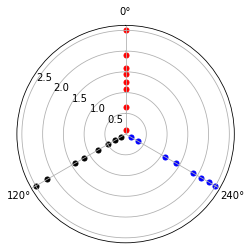

In [11]:
theta = np.zeros_like(ant.arms[0])
angles = (0, 120, 240)
r = ant.arms[0]
area = 25
fig = plt.figure()
ax = fig.add_subplot(111, projection='polar')
ax.set_thetagrids(angles)
ax.set_rlabel_position(60)
ax.set_theta_zero_location("N")
c0 = ax.scatter(theta, ant.arms[0], c='red', s=area, alpha=1)
c120 = ax.scatter(theta + np.radians(120), ant.arms[1], c='black', s=area, alpha=1)
c240 = ax.scatter(theta + np.radians(240), ant.arms[2], c='blue', s=area, alpha=1)

## Robustness of solutions

There is a reasonable question about how robust the solutions are to small changes in parameters. This will be tested by considering different potential factors

* Pixelization
* Errors in antenna position

### Pixelization 

Pixelization does not appear to change the optimization function much. Starting at a solution with 5000 pixels, and reducing the resolution so that npix=1248 results in a very similar optimium.

    python3 array_opt.py --iter=10000 --fov=160 --arcmin=360 \
        --radius=2.5 --learning-rate=0.001 \
        --initial best.json
        
Increasing the resolution to 90 arc minutes (or 22000 pixels) produces a similar result.

### Errors in Antenna position

This is tested using random offsets from the optimium array antenna positions. We expect from reference[1] that the effect on inversions of the telescope operator by perturbations of the telescope operator matrix (caused by modifications of the antenna positions) will be bounded above by the condition number, and therefore these solutions will be robust.

A numerical experiment involving adding random offsets to the antenna locations shows that this is the case. Figure, shows a histogram of condition number for solutions of a 24-element Y antenna with an arm-length of 2.5 meters. The antennas are perturbed with a zero-mean gaussian with a standard deviation of 1mm.

In [25]:
radius_min = 0.1
array_opt.init(radius_min, ant)
res = []
n_trials = 1000
delta = 1e-3   # 1 mm
for i in range(n_trials):
    x_opt = ant.x + np.random.normal(0, delta, ant.x.shape[0])
    penalty, cond = array_opt.global_f(x_opt)
    res.append(cond.numpy())
res = np.array(res)

C/N=4.367718334916967  penalty=1.1379738458742445
C/N=4.418132227352633  penalty=1.127625608981903
C/N=4.378779623002958  penalty=1.1347993931664353
C/N=4.385960489839387  penalty=1.1320300730140767
C/N=4.38048987502928  penalty=1.1464279854530444
C/N=4.373538597487572  penalty=1.1451012132976885
C/N=4.43464696400131  penalty=1.12910679418066
C/N=4.36123432986904  penalty=1.1453579399000104
C/N=4.366825528572346  penalty=1.1508256272702895
C/N=4.453512510998412  penalty=1.1249730153642803
C/N=4.439806914055699  penalty=1.1268824247822837
C/N=4.378575162396579  penalty=1.1350224510682734
C/N=4.391489094672612  penalty=1.1289813523224106
C/N=4.448831636239098  penalty=1.1199220124352336
C/N=4.453658621653157  penalty=1.1181466622818816
C/N=4.408152089510708  penalty=1.1323566451280072
C/N=4.65065223182517  penalty=1.1198954222144917
C/N=4.691411503958974  penalty=1.1429966170605195
C/N=4.474220421974072  penalty=1.1206332854462033
C/N=4.359956516685606  penalty=1.1411092896203285
C/N=4.3

C/N=4.3902549245773965  penalty=1.1318692842744353
C/N=4.4296037567078885  penalty=1.1233381338387873
C/N=4.44887311866227  penalty=1.1216780025811393
C/N=4.420853444460497  penalty=1.1220752287632911
C/N=4.378218163658767  penalty=1.140625494994883
C/N=4.4569775046482745  penalty=1.120127744467481
C/N=4.478286207898577  penalty=1.1219937646351834
C/N=4.376277793885665  penalty=1.1336437101543255
C/N=4.376933295508805  penalty=1.134685386417676
C/N=4.402128575632721  penalty=1.1262791933534937
C/N=4.354810134406021  penalty=1.1375376428941237
C/N=4.377514799268635  penalty=1.1337346578927754
C/N=4.4860401617846115  penalty=1.118175321757891
C/N=4.399429426894561  penalty=1.1269969075155624
C/N=4.38427929245507  penalty=1.1300730555886167
C/N=4.37860715341743  penalty=1.1347861621382695
C/N=4.376072664131615  penalty=1.1326657025324687
C/N=4.430722484358092  penalty=1.1296531374042038
C/N=4.340582761370693  penalty=1.1427003231834068
C/N=4.3830867327320435  penalty=1.1334085422800808
C/

C/N=4.403129941244113  penalty=1.1317963986216908
C/N=4.403781101109101  penalty=1.1312980923576734
C/N=4.458187682771294  penalty=1.1166798066823411
C/N=4.3953823336352835  penalty=1.1289517812516854
C/N=4.37500201933155  penalty=1.1332811928136444
C/N=4.369854951402098  penalty=1.1317105189182624
C/N=4.398611027729855  penalty=1.1358094906315541
C/N=4.390402678064873  penalty=1.1360729646399956
C/N=4.388531426627883  penalty=1.1401260428045716
C/N=4.366825507715824  penalty=1.140345935722655
C/N=4.408170484759337  penalty=1.1289013962670742
C/N=4.412858734838365  penalty=1.1293027116215897
C/N=4.3827052248147265  penalty=1.1321748576635353
C/N=4.354316662664519  penalty=1.137567256571102
C/N=4.404470496839899  penalty=1.1290685574809791
C/N=4.4080783762713915  penalty=1.1302128003322016
C/N=4.3659068555446465  penalty=1.1349422383023955
C/N=4.4051602703175945  penalty=1.124227517734194
C/N=4.4690785722673105  penalty=1.121879252804178
C/N=4.47292206382424  penalty=1.1386477835925037


C/N=4.395058245165608  penalty=1.1321792240229072
C/N=4.390036572340584  penalty=1.1270030991682483
C/N=4.460604292433404  penalty=1.1333372323510178
C/N=4.366290957409949  penalty=1.135994222722576
C/N=4.411646816620653  penalty=1.1384684083517687
C/N=4.441796343622519  penalty=1.1238668315442664
C/N=4.5277215148966405  penalty=1.1148495197278425
C/N=4.416348209884647  penalty=1.1309411716132023
C/N=4.3772396019901985  penalty=1.131895923405781
C/N=4.466461743263365  penalty=1.1196349548566098
C/N=4.454254180196184  penalty=1.1205657577940422
C/N=4.385787658771319  penalty=1.1278977412363649
C/N=4.433981445881935  penalty=1.1246816861548945
C/N=4.382060195751705  penalty=1.1362694459058515
C/N=4.52542891396262  penalty=1.1170347951467838
C/N=4.3868607146929355  penalty=1.1433978403638971
C/N=4.466952476443014  penalty=1.117261159737154
C/N=4.418722837611327  penalty=1.1428144227119226
C/N=4.42718520351113  penalty=1.1340901100249525
C/N=4.411017890835965  penalty=1.1239100324021505
C/

C/N=4.383203912604503  penalty=1.128584085543923
C/N=4.431633571872254  penalty=1.1265813857490385
C/N=4.4471607933194415  penalty=1.120132821053804
C/N=4.442679378940948  penalty=1.1399589966143133
C/N=4.341499045147446  penalty=1.1446924002940204
C/N=4.39893077188698  penalty=1.126415420373283
C/N=4.413910954077352  penalty=1.122237434938876
C/N=4.370499082283904  penalty=1.1324893237060834
C/N=4.354098019816287  penalty=1.1442806460908328
C/N=4.577820198255115  penalty=1.118193001633341
C/N=4.3309123688875655  penalty=1.15771485336916
C/N=4.49229589815361  penalty=1.125927102581754
C/N=4.485272480528416  penalty=1.1420535207712177
C/N=4.357527701590405  penalty=1.1366504205786785
C/N=4.5490588703412955  penalty=1.1146936381590131
C/N=4.3908352645230115  penalty=1.133674801997509
C/N=4.3984498505082  penalty=1.145450300374029
C/N=4.3635647836182105  penalty=1.1350747684594116
C/N=4.439566267161044  penalty=1.1248567328155126
C/N=4.425814263835829  penalty=1.1340208889098535
C/N=4.374

C/N=4.352375847005243  penalty=1.1372449972643923
C/N=4.374775543311254  penalty=1.136553974291292
C/N=4.494901006264661  penalty=1.12394062791956
C/N=4.378905772764501  penalty=1.13652338944594
C/N=4.618706963340305  penalty=1.114694041955814
C/N=4.395802141190646  penalty=1.12976823543004
C/N=4.4138761382220055  penalty=1.1250482299730633
C/N=4.512131761559845  penalty=1.1201463396218148
C/N=4.45575893064757  penalty=1.1261739486404452
C/N=4.406521871085428  penalty=1.1294690792167854
C/N=4.6399876634965675  penalty=1.1085618035300953
C/N=4.524897504126692  penalty=1.116363705522237
C/N=4.413851088503025  penalty=1.1281005769376546
C/N=4.6678476528702815  penalty=1.115228246080533
C/N=4.400555571592443  penalty=1.133965322137354
C/N=4.417523324027929  penalty=1.1270233736695774
C/N=4.372339793328903  penalty=1.140059479440043
C/N=4.355952959400681  penalty=1.1432861028213104
C/N=4.386028191709446  penalty=1.1324775653722476
C/N=4.453540174122274  penalty=1.1198833265305863
C/N=4.3999

C/N=4.364964928485962  penalty=1.1349785090652489
C/N=4.469943820282409  penalty=1.1221676610638422
C/N=4.52887025076624  penalty=1.1153188433777719
C/N=4.366412602236423  penalty=1.134538530578046
C/N=4.3737887689543955  penalty=1.1373546946535176
C/N=4.375275389183484  penalty=1.1384089944175468
C/N=4.349809822553575  penalty=1.138431877260028
C/N=4.4465928722293695  penalty=1.1564594411342546
C/N=4.545974500088075  penalty=1.1115872521241301
C/N=4.379934092261806  penalty=1.1386287195899778


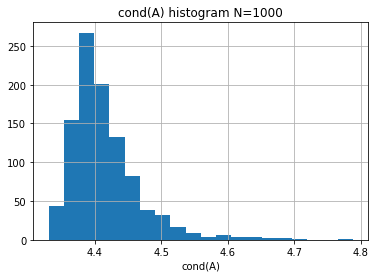

In [27]:
plt.hist(res, bins=20)
plt.title('cond(A) histogram N={}'.format(n_trials))
plt.xlabel('cond(A)')
plt.grid(True)
plt.savefig('cond_histogram.pdf')

## References

* http://www.math.bas.bg/infres/MathBalk/MB-15/MB-15-035-048.pdf An excellent overview which includes the use of K(A) to deal with Moore-Penrose inverses.
* In https://stanford.edu/~boyd/papers/pdf/diag_scaling_DR_ADMM.pdf we find the interesting statement. Minimization of the pseudo condition numberλmax/λmin>0can be posed as a convex optimization problem and be solved exactly, see [15, Section 6] which also contains heuristics to reduce the pseudo condition number. Reference 15 is ". Giselsson and S. Boyd.  Metric selection in fast dual forwardbackward splitting.Automatica, 2014." see below
* https://web.stanford.edu/~boyd/papers/pdf/metric_select_fdfbs.pdf 
* Cook, R. Dennis; Forzani, Liliana. On the mean and variance of the generalized inverse of a singular Wishart matrix. Electron. J. Statist. 5 (2011), 146--158. doi:10.1214/11-EJS602. https://projecteuclid.org/euclid.ejs/1300198786
* https://www.jstor.org/stable/2983755?seq=1 This is by Rao, and looks really really good.